<a href="https://colab.research.google.com/github/haruki0556/Chest_MRI/blob/main/Covid_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12章 カスタムデータによる画像認識

In [1]:
# 必要ライブラリ・コマンドの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
w = !apt install tree
print(w[-2])

Setting up tree (2.0.2-1) ...


In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [3]:
# PyTorch関連ライブラリのインポート

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [4]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [5]:
# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 共通関数の読み込み

In [6]:
# 共通関数のダウンロード
!git clone https://github.com/haruki0556/Chest_MRI.git

# 共通関数のロード
from Chest_MRI.common_function.utils import *

# 共通関数の存在チェック
print(README)

Cloning into 'Chest_MRI'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 29 (delta 7), reused 24 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 4.50 KiB | 4.50 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Hello!Haruki!


## 12.3 データ準備

### サンプルデータのダウンロード・解凍

In [7]:
from google.colab import files
files.upload()

Saving Covid.zip to Covid.zip


In [8]:
# データ解凍
w = !unzip -o Covid.zip

# 結果確認
print(w[-1])

  inflating: Covid19-dataset/train/Viral Pneumonia/096.jpeg  


In [9]:
# 解凍ファイルのtree表示
!tree Covid19-dataset

Covid19-dataset
├── test
│   ├── Covid
│   │   ├── 0100.jpeg
│   │   ├── 0102.jpeg
│   │   ├── 0105.png
│   │   ├── 0106.jpeg
│   │   ├── 0108.jpeg
│   │   ├── 0111.jpg
│   │   ├── 0112.jpg
│   │   ├── 0113.jpg
│   │   ├── 0115.jpeg
│   │   ├── 0118.jpeg
│   │   ├── 0119.jpeg
│   │   ├── 0120.jpg
│   │   ├── 094.png
│   │   ├── 096.png
│   │   ├── 098.jpeg
│   │   ├── auntminnie-2020_01_31_20_24_2322_2020_01_31_x-ray_coronavirus_US.jpg
│   │   ├── auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
│   │   ├── auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
│   │   ├── auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
│   │   ├── auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
│   │   ├── COVID-00003b.jpg
│   │   ├── COVID-00012.jpg
│   │   ├── COVID-00022.jpg
│   │   ├── COVID-00033.jpg
│   │   ├── COVID-00037.jpg
│   │   └── radiopaedia-2019-novel-coronavirus-infected-pneumonia.jpg
│   ├── Normal
│ 

### Transforms定義

In [10]:
# Transforms定義

# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

### データセット定義

In [11]:
# ツリーのベースディレクトリ
data_dir = 'Covid19-dataset'

# 訓練データディレクトリと検証データディレクトリの指定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# join関数の結果確認
print(train_dir, test_dir)

# 分類先クラスのリスト作成
classes = ['Covid', 'Normal','Viral Pneumonia']

Covid19-dataset/train Covid19-dataset/test


In [12]:
# データセット定義

# 訓練用
train_data = datasets.ImageFolder(train_dir,
            transform=train_transform)
# 訓練データのイメージ表示用
train_data2 = datasets.ImageFolder(train_dir,
            transform=test_transform)
# 検証用
test_data = datasets.ImageFolder(test_dir,
            transform=test_transform)

In [13]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 251件
検証データ: 66件


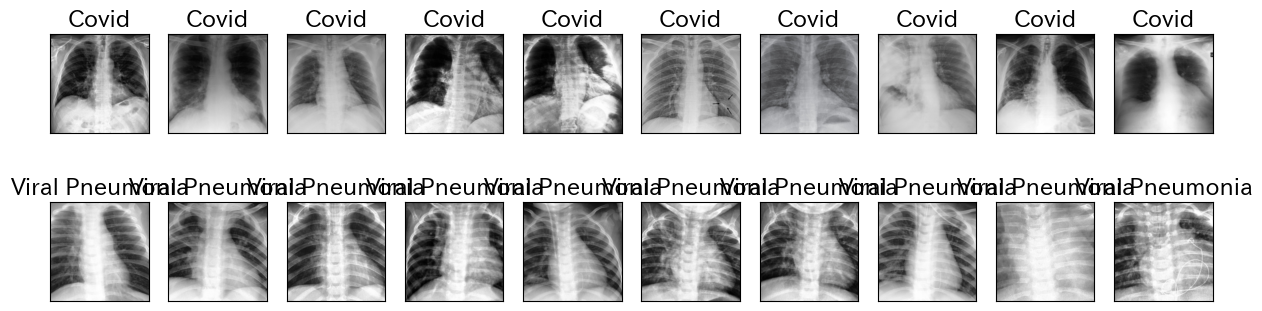

In [14]:
# 検証データ
# 最初の10個と最後の10個の表示

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = test_data[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = test_data[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### データローダー定義

In [27]:
# データローダー定義

batch_size = 20

# 訓練用
train_loader = DataLoader(train_data,
      batch_size=batch_size, shuffle=True)

# 検証用
test_loader = DataLoader(test_data,
      batch_size=batch_size, shuffle=False)

# イメージ表示用
train_loader2 = DataLoader(train_data2,
      batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data,
      batch_size=50, shuffle=True)

### イメージ表示

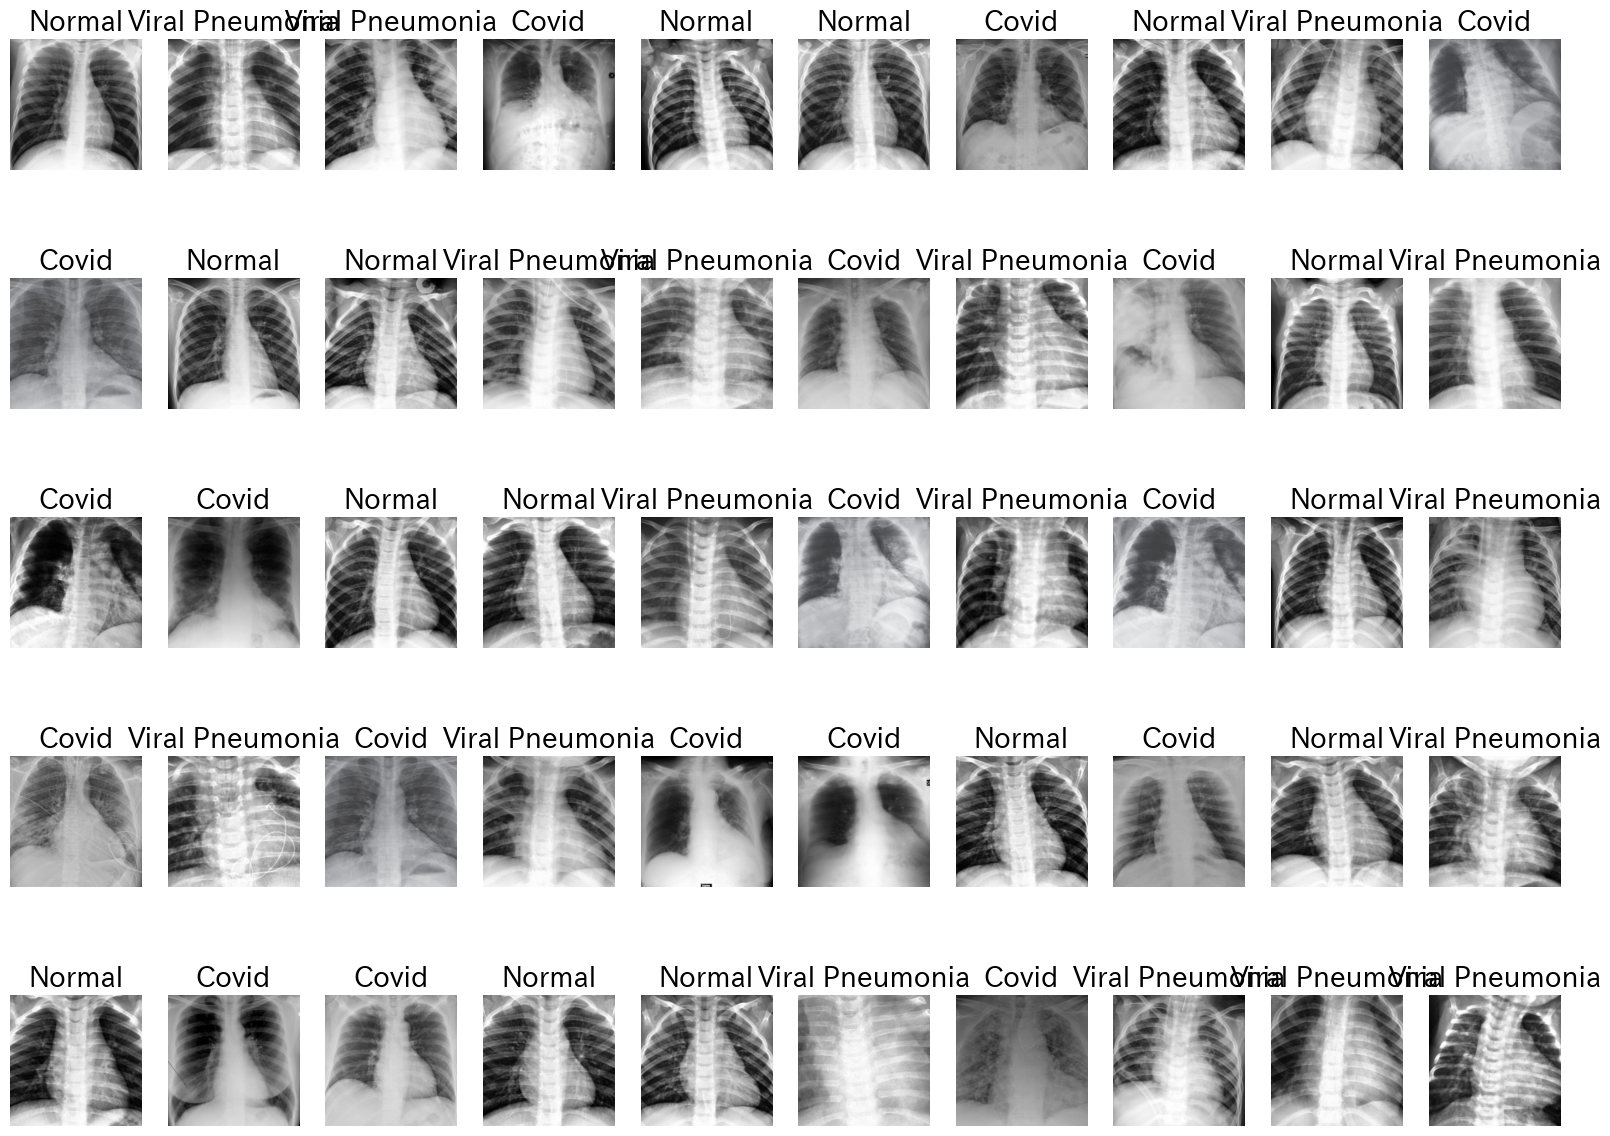

In [16]:
# 検証用データ(50件)
torch_seed()
show_images_labels(test_loader2, classes, None, None)

## 12.4 ファインチューニング版

In [20]:
# ファインチューニング版

# 学習済みモデルの読み込み
# vgg19_bnをパラメータ付きで読み込む
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 3)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [21]:
# 学習
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[1/5],loss:0.89232 acc:0.51394 test_loss:0.4823201605767915 test_acc:0.86364


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[2/5],loss:0.52944 acc:0.78486 test_loss:0.3536182125522332 test_acc:0.81818


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[3/5],loss:0.52505 acc:0.78884 test_loss:0.2646191602177692 test_acc:0.92424


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[4/5],loss:0.43357 acc:0.84462 test_loss:0.9054213809696111 test_acc:0.71212


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[5/5],loss:0.37297 acc:0.84462 test_loss:0.20329609002466453 test_acc:0.92424


In [23]:
num_epochs = 20
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[6/25],loss:0.24873 acc:0.89243 test_loss:0.23572105904476662 test_acc:0.87879


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[7/25],loss:0.33721 acc:0.88048 test_loss:0.1813617240863316 test_acc:0.95455


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[8/25],loss:0.35987 acc:0.87251 test_loss:0.2813865800889096 test_acc:0.83333


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[9/25],loss:0.24403 acc:0.92430 test_loss:0.2661528720222343 test_acc:0.83333


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[10/25],loss:0.24456 acc:0.89641 test_loss:0.16086932733676143 test_acc:0.95455


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[11/25],loss:0.24613 acc:0.90438 test_loss:0.16153927453596031 test_acc:0.95455


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[12/25],loss:0.20142 acc:0.92032 test_loss:0.2821209957945746 test_acc:0.87879


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[13/25],loss:0.20663 acc:0.91633 test_loss:0.116877760434749 test_acc:0.95455


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[14/25],loss:0.47187 acc:0.80876 test_loss:0.09890929782396239 test_acc:0.98485


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[15/25],loss:0.27778 acc:0.88446 test_loss:0.13830952840208105 test_acc:0.96970


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[16/25],loss:0.20575 acc:0.94024 test_loss:0.24294172989373858 test_acc:0.90909


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[17/25],loss:0.22258 acc:0.91235 test_loss:0.05729265460942053 test_acc:1.00000


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[18/25],loss:0.15667 acc:0.95618 test_loss:0.05497248867300875 test_acc:1.00000


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[19/25],loss:0.21475 acc:0.92829 test_loss:0.41765375769252633 test_acc:0.81818


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[20/25],loss:0.20190 acc:0.91633 test_loss:0.06085591160014949 test_acc:1.00000


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[21/25],loss:0.22554 acc:0.89243 test_loss:0.10853924559937282 test_acc:0.96970


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[22/25],loss:0.20743 acc:0.92032 test_loss:0.13142660246618712 test_acc:0.93939


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[23/25],loss:0.15391 acc:0.93625 test_loss:0.555695727010695 test_acc:0.83333


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[24/25],loss:0.20073 acc:0.91235 test_loss:0.15341079959233123 test_acc:0.92424


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch[25/25],loss:0.16147 acc:0.94024 test_loss:0.5448982343208021 test_acc:0.84848


初期状態: 損失: 0.48232 精度: 0.86364
最終状態: 損失: 0.54490 精度: 0.84848


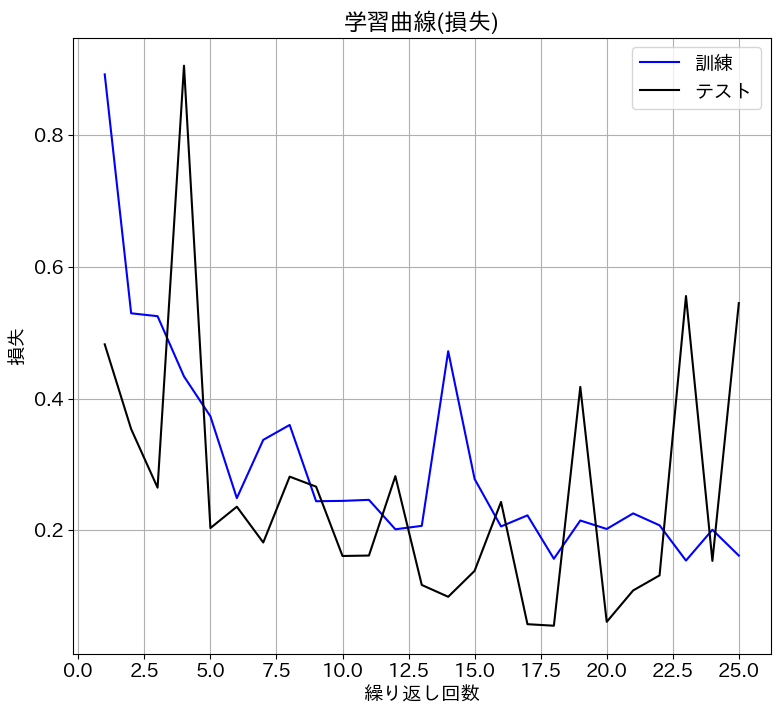

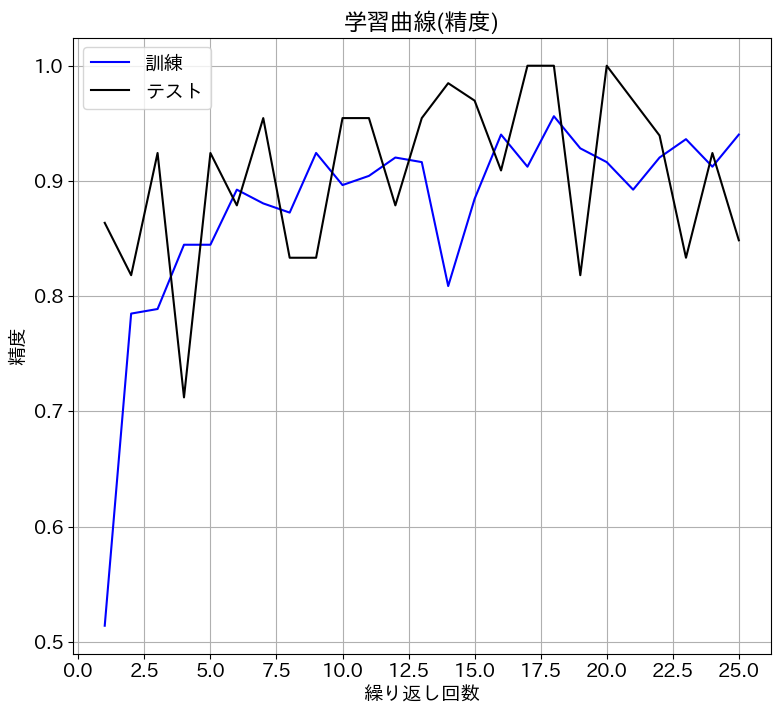

In [24]:
# 結果確認
evaluate_history(history)

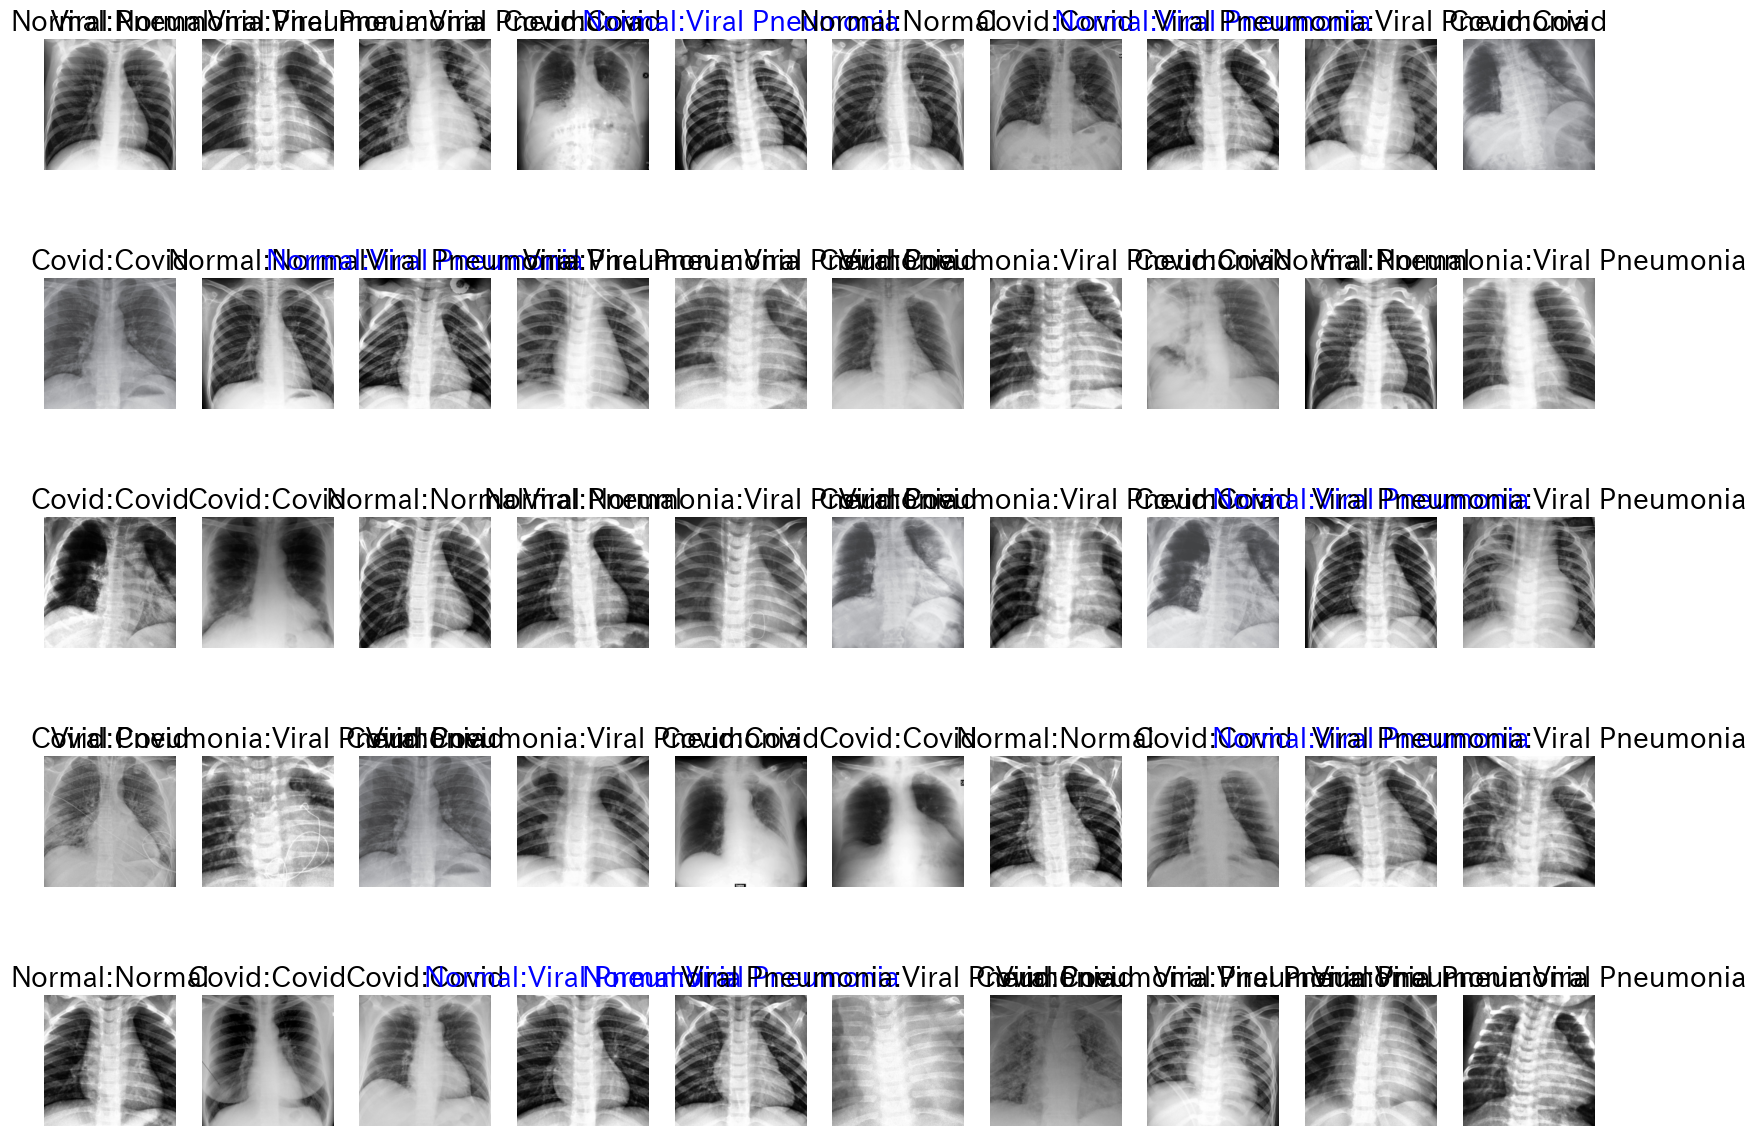

In [25]:
# 乱数初期化
torch_seed()

# 検証データへの結果表示
show_images_labels(test_loader2, classes, net, device)


## 12.5 転移学習版

In [28]:
# vgg19_bnをパラメータ付きで読み込む
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# すべてのパラメータで勾配計算なしに
for param in net.parameters():
    param.requires_grad = False

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
# このノードのみ勾配計算をすることになる
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 3)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
# パラメータ修正の対象を最終ノードに限定
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [29]:
# 学習
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[1/5],loss:1.06126 acc:0.43426 test_loss:0.8877774585377086 test_acc:0.60606


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[2/5],loss:0.85469 acc:0.62550 test_loss:0.6710210027116718 test_acc:0.83333


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[3/5],loss:0.73089 acc:0.66932 test_loss:0.5880876635060166 test_acc:0.81818


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[4/5],loss:0.66765 acc:0.69721 test_loss:0.5377388433976606 test_acc:0.83333


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[5/5],loss:0.65989 acc:0.72908 test_loss:0.4956868579893401 test_acc:0.81818


In [30]:
num_epochs = 15
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, test_loader, device, history)

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[6/20],loss:0.56960 acc:0.78884 test_loss:0.4606570312471101 test_acc:0.87879


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[7/20],loss:0.55950 acc:0.77689 test_loss:0.43297020323348767 test_acc:0.86364


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[8/20],loss:0.51996 acc:0.80080 test_loss:0.41811788533673144 test_acc:0.87879


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[9/20],loss:0.56539 acc:0.78486 test_loss:0.41314451351310266 test_acc:0.89394


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[10/20],loss:0.47655 acc:0.81673 test_loss:0.41300861763231683 test_acc:0.86364


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[11/20],loss:0.51028 acc:0.82470 test_loss:0.4103842251228564 test_acc:0.87879


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[12/20],loss:0.52885 acc:0.79681 test_loss:0.4055740607507301 test_acc:0.87879


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[13/20],loss:0.51670 acc:0.79283 test_loss:0.3841691965406591 test_acc:0.89394


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[14/20],loss:0.58913 acc:0.72908 test_loss:0.4256496519753427 test_acc:0.83333


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[15/20],loss:0.52035 acc:0.76892 test_loss:0.38678472285920923 test_acc:0.84848


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[16/20],loss:0.54228 acc:0.74104 test_loss:0.3706629845229062 test_acc:0.87879


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[17/20],loss:0.50791 acc:0.79681 test_loss:0.35588536072861066 test_acc:0.90909


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[18/20],loss:0.41243 acc:0.84861 test_loss:0.3603864908218384 test_acc:0.87879


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[19/20],loss:0.51879 acc:0.75697 test_loss:0.38144444877451117 test_acc:0.84848


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch[20/20],loss:0.47258 acc:0.84064 test_loss:0.41857508795730997 test_acc:0.78788


初期状態: 損失: 0.88778 精度: 0.60606
最終状態: 損失: 0.41858 精度: 0.78788


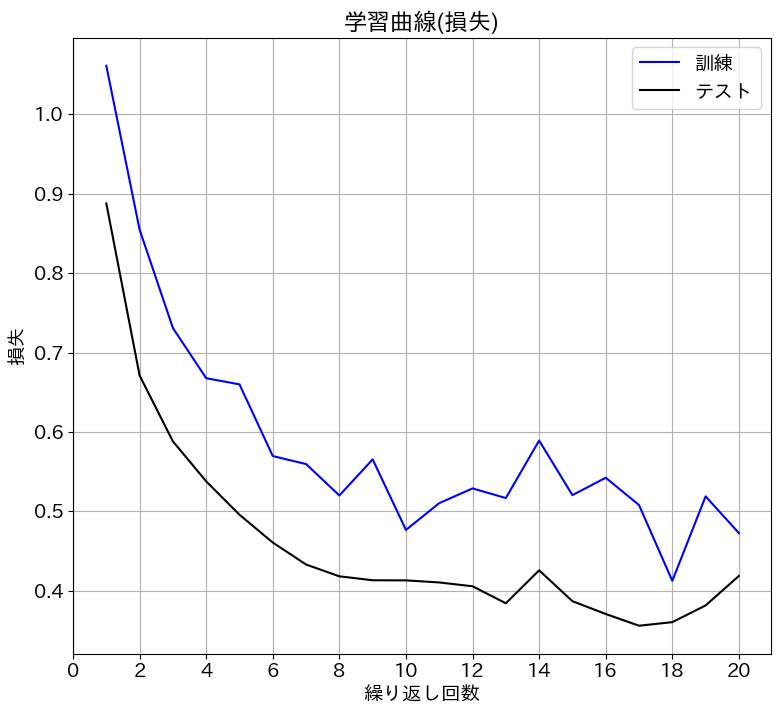

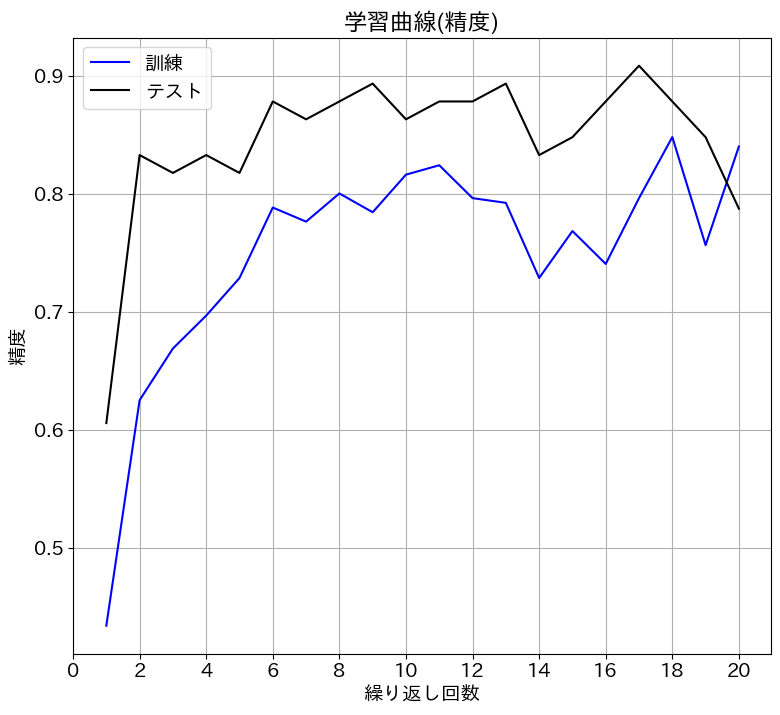

In [31]:
# 結果サマリー
evaluate_history(history)

In [ ]:
# 乱数初期化
torch_seed()

# 検証データへの結果表示
show_images_labels(test_loader2, classes, net, device)